In [2]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

In [3]:
from src.cohort import load_aki_cohort
from src.db import q
from src.utils import add_icu_los_days, add_dialysis_flag, add_early_dopamine_flag, add_sofa_score
from src.utils import add_vasopressor_flags, add_mechanical_ventilation_flag
from src.utils import add_early_late_dialysis_flags
from src.utils import add_dialysis_near_icu_discharge_flag

df_aki = load_aki_cohort()
df_aki = add_icu_los_days(df_aki)
df_aki = add_dialysis_flag(df_aki)
df_aki = add_early_dopamine_flag(df_aki, window_hours=24)
df_aki = add_sofa_score(df_aki)
df_aki = add_vasopressor_flags(df_aki, window_hours=24)
df_aki = add_mechanical_ventilation_flag(df_aki)   
df_aki.head()
df_aki.count()

subject_id                10485
hadm_id                   10485
icustay_id                10485
intime                    10485
outtime                   10485
gender                    10485
dob                       10485
admittime                 10485
dischtime                 10485
deathtime                  2295
ethnicity                 10485
age                       10485
hospital_mortality        10485
icu_los_days              10485
dialysis                  10485
early_dopamine            10485
sofa                      10485
sofa_respiration           4616
sofa_coagulation          10388
sofa_liver                 6900
sofa_cardiovascular       10294
sofa_cns                  10279
sofa_renal                10442
early_norepinephrine      10485
early_epinephrine         10485
early_phenylephrine       10485
any_vasopressor           10485
mechanical_ventilation    10485
dtype: int64

In [4]:
df_only_aki = df_aki[df_aki["sofa_renal"] > 0]
df_only_aki.count()

subject_id                8979
hadm_id                   8979
icustay_id                8979
intime                    8979
outtime                   8979
gender                    8979
dob                       8979
admittime                 8979
dischtime                 8979
deathtime                 1981
ethnicity                 8979
age                       8979
hospital_mortality        8979
icu_los_days              8979
dialysis                  8979
early_dopamine            8979
sofa                      8979
sofa_respiration          3925
sofa_coagulation          8946
sofa_liver                6057
sofa_cardiovascular       8851
sofa_cns                  8838
sofa_renal                8979
early_norepinephrine      8979
early_epinephrine         8979
early_phenylephrine       8979
any_vasopressor           8979
mechanical_ventilation    8979
dtype: int64

In [5]:
cols = [
    "sofa_respiration",
    "sofa_coagulation",
    "sofa_liver",
    "sofa_cardiovascular",
    "sofa_cns",
    "sofa_renal"
]

df_aki[cols].notna().sum()


sofa_respiration        4616
sofa_coagulation       10388
sofa_liver              6900
sofa_cardiovascular    10294
sofa_cns               10279
sofa_renal             10442
dtype: int64

In [6]:
df_aki.dropna(subset=cols).shape[0]


3160

In [7]:
df_aki["n_missing_sofa"] = df_aki[cols].isna().sum(axis=1)
df_aki["n_missing_sofa"].value_counts().sort_index()


n_missing_sofa
0    3160
1    5035
2    2086
3     116
4      45
5       2
6      41
Name: count, dtype: int64

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3217764802.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sofa_bin', 'any_vasopressor'])


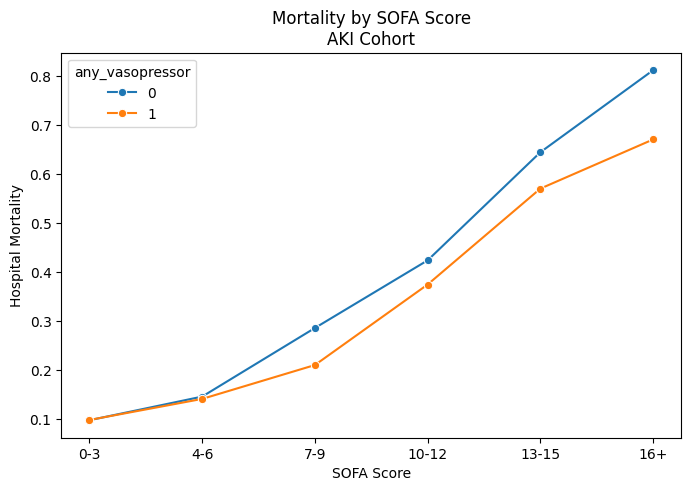

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Kopie mit relevanten Spalten
df_sub = df_aki[['sofa', 'hospital_mortality', 'any_vasopressor']].dropna()

# SOFA-Bins
df_sub['sofa_bin'] = pd.cut(
    df_sub['sofa'],
    bins=[-1, 3, 6, 9, 12, 15, 24],
    labels=['0-3', '4-6', '7-9', '10-12', '13-15', '16+']
)

# Aggregation
mortality_by_sofa = (
    df_sub
    .groupby(['sofa_bin', 'any_vasopressor'])
    .agg(
        mortality=('hospital_mortality', 'mean'),
        n=('hospital_mortality', 'size')
    )
    .reset_index()
)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=mortality_by_sofa,
    x='sofa_bin',
    y='mortality',
    hue='any_vasopressor',
    marker='o'
)
plt.ylabel('Hospital Mortality')
plt.xlabel('SOFA Score')
plt.title('Mortality by SOFA Score\nAKI Cohort')
plt.show()


C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\2221632901.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


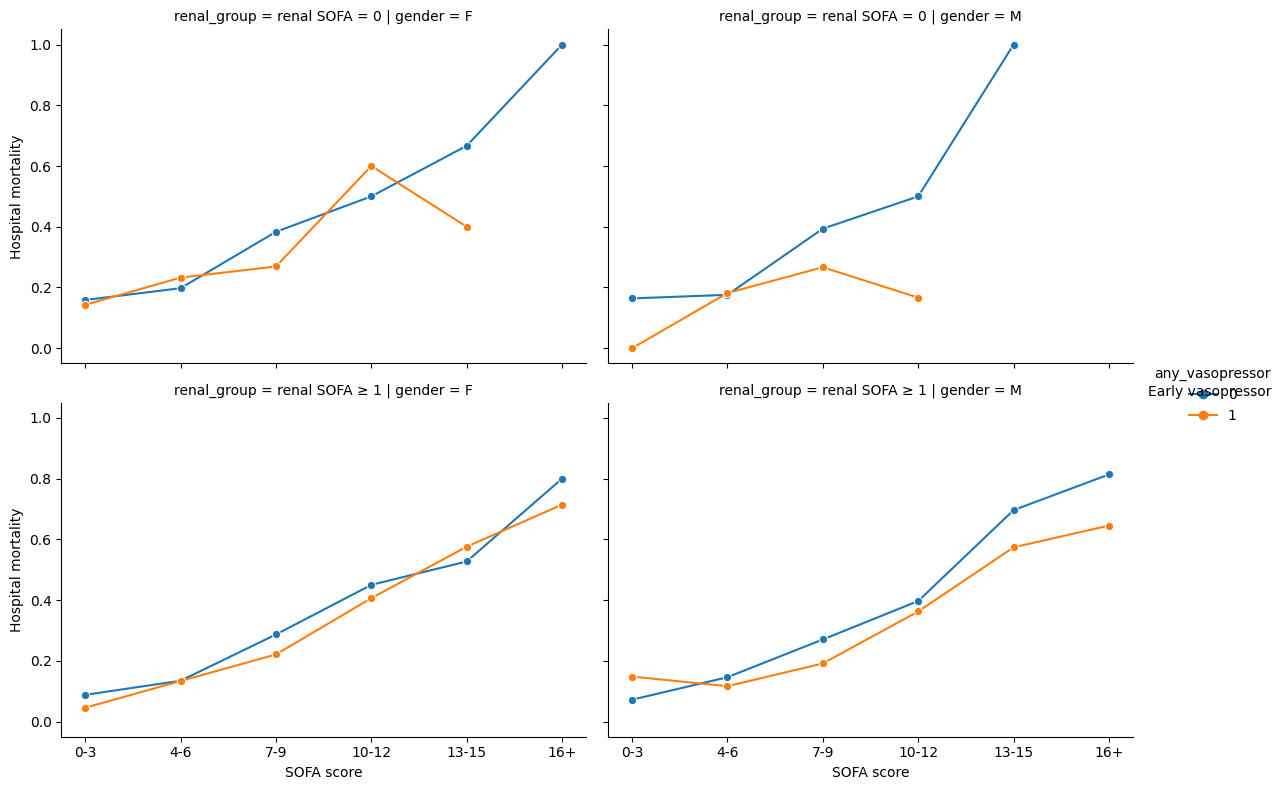

Optimization terminated successfully.
         Current function value: 0.465605
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     hospital_mortality   No. Observations:                10442
Model:                          Logit   Df Residuals:                    10435
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                  0.1157
Time:                        17:21:48   Log-Likelihood:                -4861.8
converged:                       True   LL-Null:                       -5497.9
Covariance Type:            nonrobust   LLR p-value:                1.223e-271
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -2.7640      0.072    -38.545      0.000      

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# -----------------------------
# 1) Relevante Spalten auswählen
# -----------------------------
cols = [
    'sofa',
    'sofa_renal',
    'gender',
    'hospital_mortality',
    'any_vasopressor'
]

df_sub = df_aki[cols].dropna()

# Typen absichern
df_sub['any_vasopressor'] = df_sub['any_vasopressor'].astype(int)
df_sub['hospital_mortality'] = df_sub['hospital_mortality'].astype(int)
df_sub['sofa_renal'] = df_sub['sofa_renal'].astype(int)

# -----------------------------
# 2) SOFA-Binning
# -----------------------------
# Gesamt-SOFA
df_sub['sofa_bin'] = pd.cut(
    df_sub['sofa'],
    bins=[-1, 3, 6, 9, 12, 15, 24],
    labels=['0-3', '4-6', '7-9', '10-12', '13-15', '16+']
)

# Renaler SOFA (0 vs >=1)
df_sub['renal_group'] = df_sub['sofa_renal'].apply(
    lambda x: 'renal SOFA = 0' if x == 0 else 'renal SOFA ≥ 1'
)

# -----------------------------
# 3) Gruppierung & Aggregation
# -----------------------------
mortality_grouped = (
    df_sub
    .groupby([
        'gender',
        'sofa_bin',
        'renal_group',
        'any_vasopressor'
    ])
    .agg(
        mortality=('hospital_mortality', 'mean'),
        n=('hospital_mortality', 'size')
    )
    .reset_index()
)

# -----------------------------
# 4) Visualisierung
# -----------------------------
g = sns.relplot(
    data=mortality_grouped,
    x='sofa_bin',
    y='mortality',
    hue='any_vasopressor',
    col='gender',
    row='renal_group',
    kind='line',
    marker='o',
    height=4,
    aspect=1.3
)

g.set_axis_labels("SOFA score", "Hospital mortality")
g.add_legend(title="Early vasopressor")
plt.show()

# -----------------------------
# 5) Logistische Regression (optional)
# -----------------------------
model = smf.logit(
    """
    hospital_mortality
    ~ sofa
    + sofa_renal
    + gender
    + any_vasopressor
    + sofa:any_vasopressor
    + sofa_renal:any_vasopressor
    """,
    data=df_sub
).fit()

print(model.summary())


C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3806340922.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


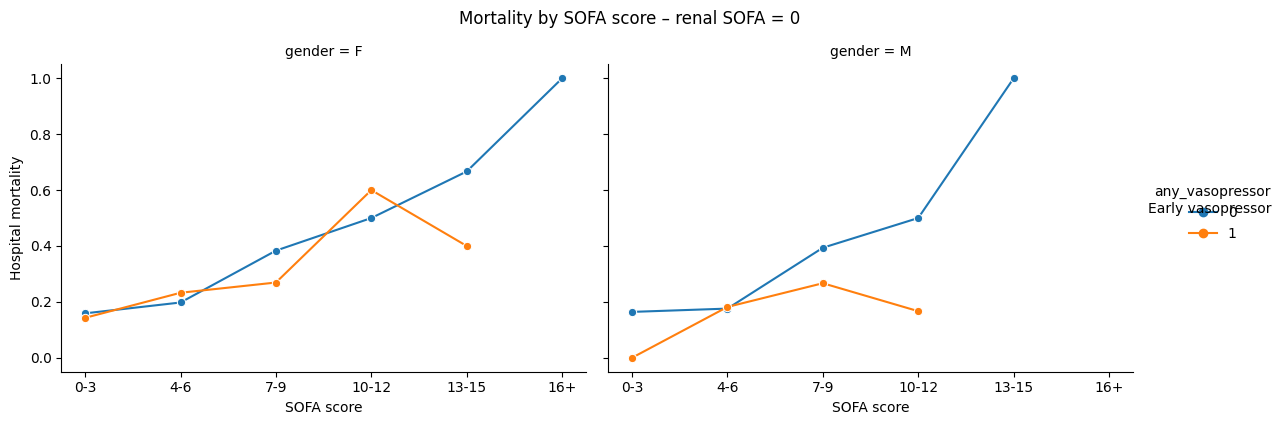

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3806340922.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


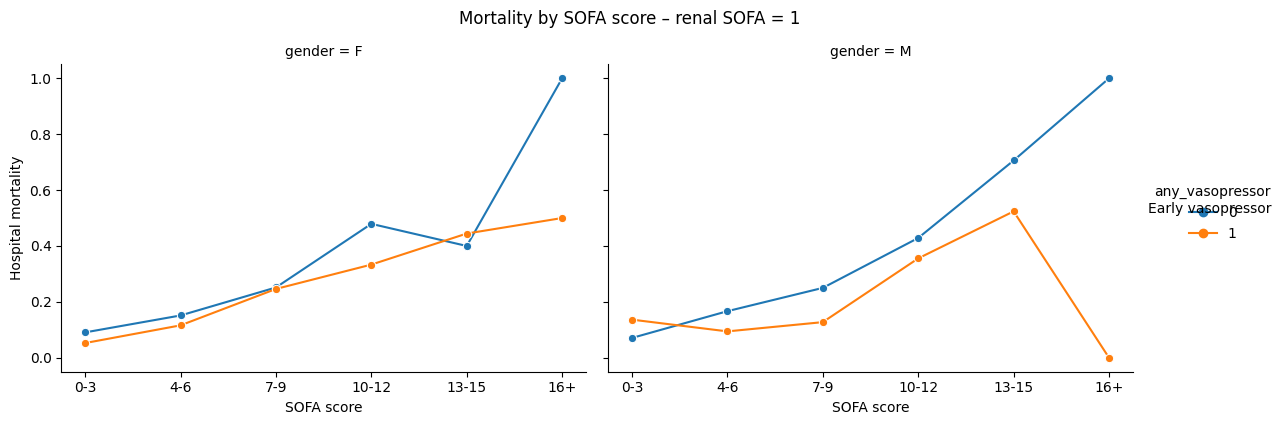

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3806340922.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


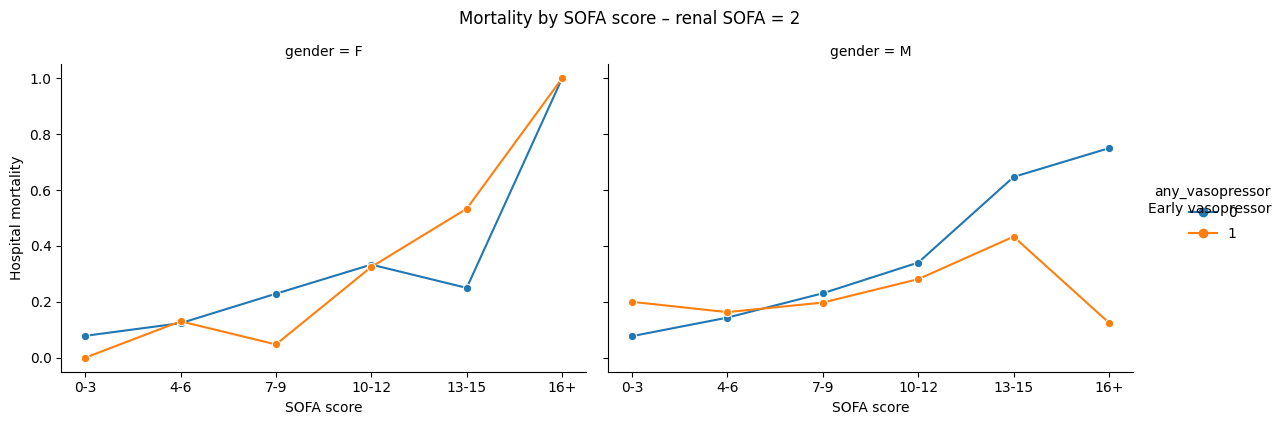

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3806340922.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


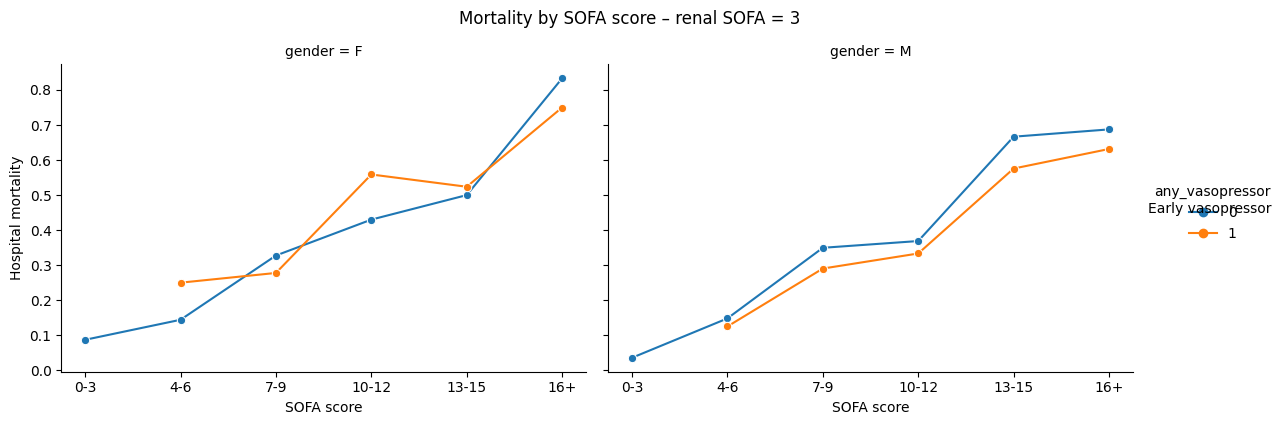

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\3806340922.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


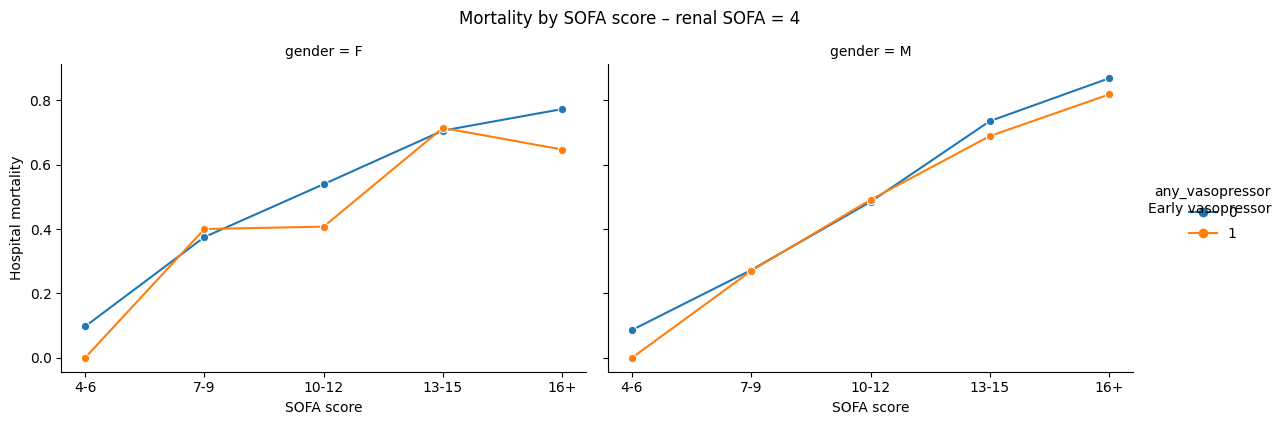

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1) Relevante Spalten
# -----------------------------
cols = [
    'sofa',
    'sofa_renal',
    'gender',
    'hospital_mortality',
    'any_vasopressor'
]

df_sub = df_aki[cols].dropna()

df_sub['any_vasopressor'] = df_sub['any_vasopressor'].astype(int)
df_sub['hospital_mortality'] = df_sub['hospital_mortality'].astype(int)
df_sub['sofa_renal'] = df_sub['sofa_renal'].astype(int)

# -----------------------------
# 2) Gesamt-SOFA binning
# -----------------------------
df_sub['sofa_bin'] = pd.cut(
    df_sub['sofa'],
    bins=[-1, 3, 6, 9, 12, 15, 24],
    labels=['0-3', '4-6', '7-9', '10-12', '13-15', '16+']
)

# -----------------------------
# 3) Loop über renalen SOFA (0–4)
# -----------------------------
for renal_score in sorted(df_sub['sofa_renal'].unique()):

    df_r = df_sub[df_sub['sofa_renal'] == renal_score]

    mortality_grouped = (
        df_r
        .groupby([
            'gender',
            'sofa_bin',
            'any_vasopressor'
        ])
        .agg(
            mortality=('hospital_mortality', 'mean'),
            n=('hospital_mortality', 'size')
        )
        .reset_index()
    )

    g = sns.relplot(
        data=mortality_grouped,
        x='sofa_bin',
        y='mortality',
        hue='any_vasopressor',
        col='gender',
        kind='line',
        marker='o',
        height=4,
        aspect=1.3
    )

    g.set_axis_labels("SOFA score", "Hospital mortality")
    g.add_legend(title="Early vasopressor")
    g.fig.suptitle(
        f"Mortality by SOFA score – renal SOFA = {renal_score}",
        y=1.05
    )

    plt.show()


In [11]:
import numpy as np
import pandas as pd
from scipy import stats

# ============================================================
# 2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR
# Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score
# ============================================================

# -----------------------------
# 0) Konfiguration (Bins/Labels)
# -----------------------------
RENAL_BINS = {
    "Mild (0-1)": [0, 1],
    "Moderat (2)": [2],
    "Schwer (3-4)": [3, 4],
}

TOTAL_SOFA_BINS = [
    ("Mild (0-3)", 0, 3),
    ("Moderat (4-7)", 4, 7),
    ("Schwer (8-24)", 8, 24),
]

# -----------------------------
# 1) Hilfsfunktionen
# -----------------------------
def format_pp(x):
    # percentage points with sign, one decimal
    return f"{x:+.1f}pp"

def format_pct(x):
    return f"{100*x:5.1f}%"

def format_float(x):
    return f"{x:5.1f}"

def stars(p):
    if p < 0.001:
        return " ***"
    if p < 0.01:
        return " **"
    if p < 0.05:
        return " *"
    return ""

def fisher_or_chi2_p(a, b, c, d):
    """
    2x2 table:
        event   noevent
    grp1  a       b
    grp0  c       d
    Use Fisher if any expected cell < 5, else Chi-square.
    Returns p-value (float).
    """
    table = np.array([[a, b], [c, d]], dtype=float)

    # If any row/col sums to 0 -> undefined, return nan
    if table.sum() == 0 or (table.sum(axis=1) == 0).any() or (table.sum(axis=0) == 0).any():
        return np.nan

    chi2, p_chi, dof, exp = stats.chi2_contingency(table, correction=False)
    if (exp < 5).any():
        _, p_f = stats.fisher_exact(table)
        return p_f
    return p_chi

def mw_p(x1, x0):
    """
    Mann-Whitney U test (two-sided). Robust for LOS-like skew.
    Returns p-value.
    """
    # Need at least 1 observation per group
    if len(x1) == 0 or len(x0) == 0:
        return np.nan
    try:
        _, p = stats.mannwhitneyu(x1, x0, alternative="two-sided")
        return p
    except Exception:
        return np.nan

def header(title):
    line = "=" * 120
    print(line)
    print(title)
    print(line)
    print()

# -----------------------------
# 2) Daten vorbereiten
# -----------------------------
# Erwartete Spalten: sofa, sofa_renal, hospital_mortality, icu_los_days, dialysis, any_vasopressor
need_cols = ["sofa", "sofa_renal", "hospital_mortality", "icu_los_days", "dialysis", "any_vasopressor"]
missing = [c for c in need_cols if c not in df_aki.columns]
if missing:
    raise ValueError(f"Fehlende Spalten in df_aki: {missing}")

d = df_aki[need_cols].copy().dropna()
# Typen absichern
d["sofa"] = pd.to_numeric(d["sofa"], errors="coerce")
d["sofa_renal"] = pd.to_numeric(d["sofa_renal"], errors="coerce")
d["hospital_mortality"] = d["hospital_mortality"].astype(int)
d["dialysis"] = d["dialysis"].astype(int)
d["any_vasopressor"] = d["any_vasopressor"].astype(int)

d = d.dropna(subset=["sofa", "sofa_renal"])

# -----------------------------
# 3) Analyse & Textreport
# -----------------------------
header(
    "2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR\n"
    "Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score (Gesamtschweregrad)"
)

# Für die Zusammenfassung am Ende
summary_rows = []

for renal_label, renal_vals in RENAL_BINS.items():
    for total_label, lo, hi in TOTAL_SOFA_BINS:
        mask = d["sofa_renal"].isin(renal_vals) & d["sofa"].between(lo, hi, inclusive="both")
        sub = d.loc[mask].copy()

        # Split groups
        g1 = sub[sub["any_vasopressor"] == 1]
        g0 = sub[sub["any_vasopressor"] == 0]

        n_total = len(sub)
        n1 = len(g1)
        n0 = len(g0)

        # Skip empty strata (optional: print them too)
        if n_total == 0:
            continue

        # ---------- Mortality ----------
        m1 = g1["hospital_mortality"].mean() if n1 > 0 else np.nan
        m0 = g0["hospital_mortality"].mean() if n0 > 0 else np.nan
        d_m_pp = (m1 - m0) * 100 if (np.isfinite(m1) and np.isfinite(m0)) else np.nan

        # 2x2 for mortality
        a = int(g1["hospital_mortality"].sum()) if n1 > 0 else 0
        b = int(n1 - a) if n1 > 0 else 0
        c = int(g0["hospital_mortality"].sum()) if n0 > 0 else 0
        dd = int(n0 - c) if n0 > 0 else 0
        p_mort = fisher_or_chi2_p(a, b, c, dd) if (n1 > 0 and n0 > 0) else np.nan

        # ---------- ICU LOS ----------
        los1 = g1["icu_los_days"].astype(float).dropna().values
        los0 = g0["icu_los_days"].astype(float).dropna().values
        los_mean1 = np.mean(los1) if len(los1) > 0 else np.nan
        los_mean0 = np.mean(los0) if len(los0) > 0 else np.nan
        d_los = (los_mean1 - los_mean0) if (np.isfinite(los_mean1) and np.isfinite(los_mean0)) else np.nan
        p_los = mw_p(los1, los0) if (n1 > 0 and n0 > 0) else np.nan

        # ---------- Dialysis ----------
        dy1 = g1["dialysis"].mean() if n1 > 0 else np.nan
        dy0 = g0["dialysis"].mean() if n0 > 0 else np.nan
        d_dy_pp = (dy1 - dy0) * 100 if (np.isfinite(dy1) and np.isfinite(dy0)) else np.nan

        a2 = int(g1["dialysis"].sum()) if n1 > 0 else 0
        b2 = int(n1 - a2) if n1 > 0 else 0
        c2 = int(g0["dialysis"].sum()) if n0 > 0 else 0
        d2 = int(n0 - c2) if n0 > 0 else 0
        p_dial = fisher_or_chi2_p(a2, b2, c2, d2) if (n1 > 0 and n0 > 0) else np.nan

        # ---------- Block print ----------
        line = "=" * 120
        print(line)
        print(f"Renal: {renal_label:<14} | Gesamt: {total_label:<14} | n={n_total:4d} (Mit Vaso: {n1}, Ohne: {n0})")
        print(line)

        mort_str = (
            f"Mortalität:     Mit {format_pct(m1)} vs Ohne {format_pct(m0)} "
            f"(Δ {format_pp(d_m_pp)}, p={p_mort:.3f}{stars(p_mort)} )"
            if np.isfinite(m1) and np.isfinite(m0) and np.isfinite(p_mort)
            else "Mortalität:     (nicht berechenbar – eine Gruppe leer oder Werte fehlen)"
        )

        los_str = (
            f"ICU-LOS (Tage):  Mit {format_float(los_mean1)}  vs Ohne {format_float(los_mean0)}  "
            f"(Δ {d_los:+.1f} Tage, p={p_los:.3f}{stars(p_los)} )"
            if np.isfinite(los_mean1) and np.isfinite(los_mean0) and np.isfinite(p_los)
            else "ICU-LOS (Tage): (nicht berechenbar – eine Gruppe leer oder Werte fehlen)"
        )

        dial_str = (
            f"Dialysepflicht: Mit {format_pct(dy1)} vs Ohne {format_pct(dy0)} "
            f"(Δ {format_pp(d_dy_pp)}, p={p_dial:.3f}{stars(p_dial)} )"
            if np.isfinite(dy1) and np.isfinite(dy0) and np.isfinite(p_dial)
            else "Dialysepflicht: (nicht berechenbar – eine Gruppe leer oder Werte fehlen)"
        )

        print(mort_str)
        print(los_str)
        print(dial_str)
        print()

        # ---------- Collect summary ----------
        summary_rows.append({
            "renal_stratum": renal_label,
            "total_sofa_stratum": total_label,
            "n": n_total,
            "n_vaso": n1,
            "n_no_vaso": n0,
            "mort_with": m1,
            "mort_without": m0,
            "delta_pp": d_m_pp,
            "p_mort": p_mort
        })

# -----------------------------
# 4) Zusammenfassung: Mortalitätsdifferenzen
# -----------------------------
print("=" * 120)
print("ZUSAMMENFASSUNG: Mortalitäts-Differenz (Mit Vasopressor - Ohne Vasopressor) in Prozentpunkten")
print("=" * 120)
print()

if len(summary_rows) == 0:
    print("Keine Strata mit Daten gefunden.")
else:
    s = pd.DataFrame(summary_rows)

    # Sort: renal severity, then total severity
    renal_order = list(RENAL_BINS.keys())
    total_order = [x[0] for x in TOTAL_SOFA_BINS]
    s["renal_stratum"] = pd.Categorical(s["renal_stratum"], categories=renal_order, ordered=True)
    s["total_sofa_stratum"] = pd.Categorical(s["total_sofa_stratum"], categories=total_order, ordered=True)
    s = s.sort_values(["renal_stratum", "total_sofa_stratum"])

    for _, r in s.iterrows():
        if pd.isna(r["delta_pp"]) or pd.isna(r["p_mort"]):
            delta_str = "n/a"
            p_str = "n/a"
            st = ""
        else:
            delta_str = f"{r['delta_pp']:+.1f}pp"
            p_str = f"{r['p_mort']:.3f}"
            st = stars(r["p_mort"])

        print(
            f"Renal: {str(r['renal_stratum']):<14} | Gesamt: {str(r['total_sofa_stratum']):<14} | "
            f"n={int(r['n']):4d} (Vaso {int(r['n_vaso'])}, Ohne {int(r['n_no_vaso'])}) | "
            f"ΔMort={delta_str:>7} | p={p_str}{st}"
        )


2D-STRATIFIZIERTE ANALYSE: EARLY VASOPRESSOR
Nach SOFA-Renal Score (Nierenfunktion) UND Gesamt-SOFA Score (Gesamtschweregrad)

Renal: Mild (0-1)     | Gesamt: Mild (0-3)     | n=2215 (Mit Vaso: 73, Ohne: 2142)
Mortalität:     Mit   9.6% vs Ohne  10.6% (Δ -1.0pp, p=0.783 )
ICU-LOS (Tage):  Mit   5.8  vs Ohne   4.2  (Δ +1.6 Tage, p=0.000 *** )
Dialysepflicht: Mit   2.7% vs Ohne   3.3% (Δ -0.5pp, p=1.000 )

Renal: Mild (0-1)     | Gesamt: Moderat (4-7)  | n=1991 (Mit Vaso: 326, Ohne: 1665)
Mortalität:     Mit  13.5% vs Ohne  18.0% (Δ -4.5pp, p=0.048 * )
ICU-LOS (Tage):  Mit   7.2  vs Ohne   6.7  (Δ +0.5 Tage, p=0.105 )
Dialysepflicht: Mit   6.1% vs Ohne   5.2% (Δ +1.0pp, p=0.476 )

Renal: Mild (0-1)     | Gesamt: Schwer (8-24)  | n= 855 (Mit Vaso: 276, Ohne: 579)
Mortalität:     Mit  29.7% vs Ohne  38.0% (Δ -8.3pp, p=0.018 * )
ICU-LOS (Tage):  Mit  10.0  vs Ohne  10.0  (Δ +0.0 Tage, p=0.184 )
Dialysepflicht: Mit  10.1% vs Ohne  11.4% (Δ -1.3pp, p=0.584 )

Renal: Moderat (2)    | Gesamt: M

Stratum size: n=1529
any_vasopressor
0    1071
1     458
Name: count, dtype: int64

--- Unadjustiert (Stratum) ---
n total=1529 (Vaso=458, NoVaso=1071)
Mortality: Vaso=52.6% vs NoVaso=48.2%  (Δ +4.4pp), p=0.112 [Chi-square]

--- Adjustiertes Modell (mit dialysis) ---
                           Logit Regression Results                           
Dep. Variable:     hospital_mortality   No. Observations:                 1529
Model:                          Logit   Df Residuals:                     1523
Method:                           MLE   Df Model:                            5
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                  0.1030
Time:                        17:21:51   Log-Likelihood:                -950.58
converged:                       True   LL-Null:                       -1059.7
Covariance Type:            nonrobust   LLR p-value:                 3.364e-45
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

C:\Users\Simon\AppData\Local\Temp\ipykernel_22344\847632750.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["sofa_bin", "any_vasopressor"])


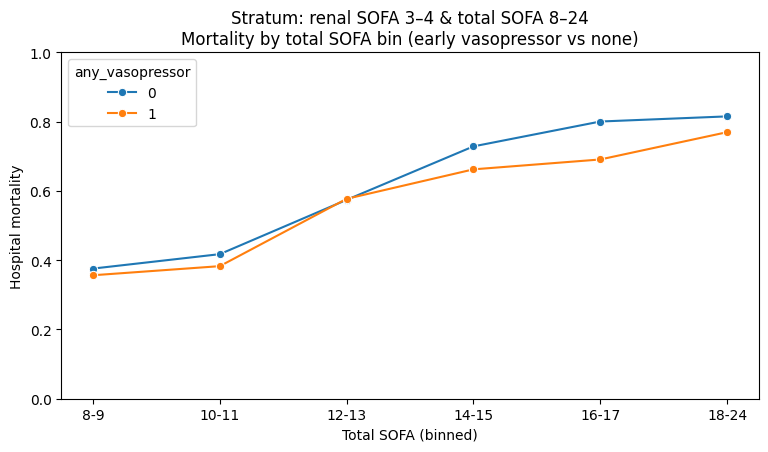


--- Aggregation (für Plot) ---
   sofa_bin  any_vasopressor  mortality    n
0       8-9                0   0.375587  426
1       8-9                1   0.356322   87
2     10-11                0   0.417219  302
3     10-11                1   0.382609  115
4     12-13                0   0.573964  169
5     12-13                1   0.576923  104
6     14-15                0   0.728261   92
7     14-15                1   0.661972   71
8     16-17                0   0.800000   55
9     16-17                1   0.690476   42
10    18-24                0   0.814815   27
11    18-24                1   0.769231   39


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

# ============================================================
# Fokus-Stratum: Renal SOFA 3–4 UND Gesamt-SOFA 8–24
# Ziel: (1) Deskriptiv + Tests, (2) Adjustierte logistische Regression,
#       (3) Plot Mortalität vs. SOFA (glatt) nach Vasopressor
# Erwartete Spalten in df:
#   sofa, sofa_renal, hospital_mortality, any_vasopressor,
#   age, mechanical_ventilation, dialysis, icu_los_days (optional)
# ============================================================

# -----------------------------
# 1) Subset für das Stratum
# -----------------------------
need_cols = ["sofa", "sofa_renal", "hospital_mortality", "any_vasopressor",
             "age", "mechanical_ventilation", "dialysis"]
missing = [c for c in need_cols if c not in df_aki.columns]
if missing:
    raise ValueError(f"Fehlende Spalten in df_aki: {missing}")

sub = df_aki[need_cols].copy().dropna()
# Typen absichern
sub["sofa"] = pd.to_numeric(sub["sofa"], errors="coerce")
sub["sofa_renal"] = pd.to_numeric(sub["sofa_renal"], errors="coerce")
sub["hospital_mortality"] = sub["hospital_mortality"].astype(int)
sub["any_vasopressor"] = sub["any_vasopressor"].astype(int)
sub["dialysis"] = sub["dialysis"].astype(int)
sub["mechanical_ventilation"] = sub["mechanical_ventilation"].astype(int)
sub["age"] = pd.to_numeric(sub["age"], errors="coerce")

sub = sub.dropna(subset=["sofa", "sofa_renal", "age"])

# Stratum-Filter
sub = sub[sub["sofa_renal"].isin([3, 4]) & sub["sofa"].between(8, 24, inclusive="both")].copy()

print(f"Stratum size: n={len(sub)}")
print(sub["any_vasopressor"].value_counts(dropna=False))

# -----------------------------
# 2) Deskriptiv + unadjustierter Test (Mortalität)
# -----------------------------
g1 = sub[sub["any_vasopressor"] == 1]
g0 = sub[sub["any_vasopressor"] == 0]

n1, n0 = len(g1), len(g0)
m1 = g1["hospital_mortality"].mean() if n1 > 0 else np.nan
m0 = g0["hospital_mortality"].mean() if n0 > 0 else np.nan
delta_pp = (m1 - m0) * 100 if np.isfinite(m1) and np.isfinite(m0) else np.nan

# 2x2 p-value (Fisher if needed, else Chi-square)
a = int(g1["hospital_mortality"].sum()) if n1 > 0 else 0
b = int(n1 - a) if n1 > 0 else 0
c = int(g0["hospital_mortality"].sum()) if n0 > 0 else 0
d_ = int(n0 - c) if n0 > 0 else 0
table = np.array([[a, b], [c, d_]], dtype=float)

if n1 > 0 and n0 > 0 and table.sum() > 0:
    chi2, p_chi, dof, exp = stats.chi2_contingency(table, correction=False)
    if (exp < 5).any():
        _, p_mort = stats.fisher_exact(table)
        test_used = "Fisher"
    else:
        p_mort = p_chi
        test_used = "Chi-square"
else:
    p_mort = np.nan
    test_used = "n/a"

print("\n--- Unadjustiert (Stratum) ---")
print(f"n total={len(sub)} (Vaso={n1}, NoVaso={n0})")
print(f"Mortality: Vaso={m1*100:.1f}% vs NoVaso={m0*100:.1f}%  (Δ {delta_pp:+.1f}pp), p={p_mort:.3f} [{test_used}]")

# -----------------------------
# 3) Adjustierte logistische Regression im Stratum
#    (Kontinuierlicher SOFA, Alter, MV, Dialyse)
# -----------------------------
# Hinweis: dialysis kann (teilweise) post-baseline sein -> Sensitivität: Modell ohne dialysis unten.
model1 = smf.logit(
    "hospital_mortality ~ any_vasopressor + sofa + age + mechanical_ventilation + dialysis",
    data=sub
).fit(disp=False)

print("\n--- Adjustiertes Modell (mit dialysis) ---")
print(model1.summary())

# Odds Ratio + 95% CI für any_vasopressor
params = model1.params
conf = model1.conf_int()
or_vaso = float(np.exp(params["any_vasopressor"]))
ci_lo, ci_hi = np.exp(conf.loc["any_vasopressor"].values)
p_vaso = float(model1.pvalues["any_vasopressor"])
print(f"\nAdjusted OR (any_vasopressor): {or_vaso:.3f}  (95% CI {ci_lo:.3f}–{ci_hi:.3f}), p={p_vaso:.3f}")

# Sensitivität: ohne dialysis
model2 = smf.logit(
    "hospital_mortality ~ any_vasopressor + sofa + age + mechanical_ventilation",
    data=sub
).fit(disp=False)

print("\n--- Sensitivität (ohne dialysis) ---")
print(model2.summary())

params2 = model2.params
conf2 = model2.conf_int()
or_vaso2 = float(np.exp(params2["any_vasopressor"]))
ci_lo2, ci_hi2 = np.exp(conf2.loc["any_vasopressor"].values)
p_vaso2 = float(model2.pvalues["any_vasopressor"])
print(f"\nAdjusted OR (any_vasopressor) [no dialysis]: {or_vaso2:.3f}  (95% CI {ci_lo2:.3f}–{ci_hi2:.3f}), p={p_vaso2:.3f}")

# -----------------------------
# 4) Visual: Mortalität vs SOFA (binned) im Stratum
# -----------------------------
sub_plot = sub.copy()
sub_plot["sofa_bin"] = pd.cut(
    sub_plot["sofa"],
    bins=[7, 9, 11, 13, 15, 17, 24],  # 8-9, 10-11, 12-13, ...
    labels=["8-9", "10-11", "12-13", "14-15", "16-17", "18-24"]
)

agg = (sub_plot
       .groupby(["sofa_bin", "any_vasopressor"])
       .agg(mortality=("hospital_mortality", "mean"),
            n=("hospital_mortality", "size"))
       .reset_index())

plt.figure(figsize=(9, 4.5))
sns.lineplot(data=agg, x="sofa_bin", y="mortality", hue="any_vasopressor", marker="o")
plt.ylabel("Hospital mortality")
plt.xlabel("Total SOFA (binned)")
plt.title("Stratum: renal SOFA 3–4 & total SOFA 8–24\nMortality by total SOFA bin (early vasopressor vs none)")
plt.ylim(0, 1)
plt.show()

# Optional: n-Table anzeigen
print("\n--- Aggregation (für Plot) ---")
print(agg.sort_values(["sofa_bin", "any_vasopressor"]))


In [13]:
df2 = add_early_late_dialysis_flags(df_aki, window_hours=24)

# Wie oft passiert ICD-only?
print(df2[["dialysis", "dialysis_timed", "dialysis_icd_only", "early_dialysis", "late_dialysis"]].value_counts())

print("dialysis==1:", (df2["dialysis"] == 1).sum())
print("timed dialysis:", (df2["dialysis_timed"] == 1).sum())
print("ICD-only dialysis:", (df2["dialysis_icd_only"] == 1).sum())

dialysis  dialysis_timed  dialysis_icd_only  early_dialysis  late_dialysis
0         0               0                  0               0                9095
1         0               1                  0               0                 781
          1               0                  0               1                 323
                                             1               0                 282
0         1               0                  1               0                   3
                                             0               1                   1
Name: count, dtype: int64
dialysis==1: 1386
timed dialysis: 609
ICD-only dialysis: 781


In [14]:
from src.utils import extract_dialysis_timing

df2 = extract_dialysis_timing(df2)

df2["dialysis_timed"] = df2["dialysis_start"].notna().astype(int)

df2["hours_to_dialysis"] = (
    (df2["dialysis_start"] - df2["intime"])
    .dt.total_seconds() / 3600
)

df2["early_dialysis"] = (
    (df2["hours_to_dialysis"] >= 0) &
    (df2["hours_to_dialysis"] <= 24)
).astype(int)

df2["late_dialysis"] = (
    df2["hours_to_dialysis"] > 24
).astype(int)

df2["persistent_dialysis_48h"] = (
    df2["dialysis_duration_hours"] >= 48
).astype(int)


df2["persistent_dialysis_48h"].value_counts()



persistent_dialysis_48h
0    10021
1      464
Name: count, dtype: int64

In [15]:
from src.utils import add_dialysis_near_icu_discharge_flag
df2 = add_dialysis_near_icu_discharge_flag(df2, hours_before_discharge=6)

df2["dialysis_last_6h"].value_counts(dropna=False)


dialysis_last_6h
0    10020
1      465
Name: count, dtype: int64

In [16]:
cols = [
    "dialysis", "dialysis_timed", "dialysis_icd_only",
    "early_dialysis", "late_dialysis",
    "dialysis_start", "dialysis_end", "dialysis_duration_hours",
    "dialysis_last_6h"
]
print(df2[cols].value_counts().head(20))

print("dialysis==1:", (df2["dialysis"] == 1).sum())
print("dialysis_timed==1:", (df2["dialysis_timed"] == 1).sum())
print("dialysis_icd_only==1:", (df2["dialysis_icd_only"] == 1).sum())

dialysis  dialysis_timed  dialysis_icd_only  early_dialysis  late_dialysis  dialysis_start       dialysis_end         dialysis_duration_hours  dialysis_last_6h
0         1               0                  0               1              2162-11-03 06:27:00  2162-11-03 16:27:00  10.000000                0                   1
                                             1               0              2117-02-14 02:28:00  2117-02-14 08:07:00  5.650000                 0                   1
                                                                            2125-09-07 03:46:00  2125-09-07 04:46:00  1.000000                 0                   1
                                                                            2159-09-15 07:46:00  2159-09-15 08:46:00  1.000000                 0                   1
1         1               0                  0               1              2100-12-14 13:26:00  2100-12-23 18:35:00  221.150000               1                   1
               

In [17]:
from src.utils import add_rrt_persistence_near_discharge
df2 = add_rrt_persistence_near_discharge(
    df2,
    hours_before_discharge=6,
    min_overlap_hours=3,     # <- macht es "nicht nur vorübergehend"
    gap_tolerance_hours=2
)
df2.count()

# df2[["rrt_any_in_last6h", "rrt_active_at_outtime", "rrt_persistent_last6h", "rrt_max_overlap_hours_in_window"]].value_counts().head(10)
df2[df2["rrt_max_overlap_hours_in_window"] >= 5.9].count()

subject_id                         432
hadm_id                            432
icustay_id                         432
intime                             432
outtime                            432
gender                             432
dob                                432
admittime                          432
dischtime                          432
deathtime                          197
ethnicity                          432
age                                432
hospital_mortality                 432
icu_los_days                       432
dialysis                           432
early_dopamine                     432
sofa                               432
sofa_respiration                   262
sofa_coagulation                   431
sofa_liver                         357
sofa_cardiovascular                430
sofa_cns                           430
sofa_renal                         432
early_norepinephrine               432
early_epinephrine                  432
early_phenylephrine      

In [19]:
from src.utils import add_dialysis_dependent_at_discharge_flag
df2 = add_dialysis_dependent_at_discharge_flag(df2)
df2["dialysis_dependent_discharge"].value_counts()

dialysis_dependent_discharge
0    10141
1      344
Name: count, dtype: int64

In [20]:
sub = df2[
    (df2["sofa"] >= 8) &
    (df2["sofa_renal"] >= 3)
].copy()

print("Subgroup size:", len(sub))
print(sub["any_vasopressor"].value_counts())


Subgroup size: 1529
any_vasopressor
0    1071
1     458
Name: count, dtype: int64


In [21]:
primary = sub[
    (sub["early_dialysis"] == 0) &
    (sub["dialysis_timed"] == 1)
].copy()

print("Primary analysis n:", len(primary))


Primary analysis n: 126


In [32]:
primary = sub[
    (sub["early_dialysis"] == 0) &
    (sub["dialysis_timed"] == 1)   # nur wenn Timing sinnvoll
].copy()

print("Primary analysis n:", len(primary))


Primary analysis n: 126


In [33]:


g1 = primary[primary["any_vasopressor"] == 1]
g0 = primary[primary["any_vasopressor"] == 0]
print("Sensitivity analysis n:", len(g1) + len(g0))

rate1 = g1["rrt_persistent_last6h"].mean()
rate0 = g0["rrt_persistent_last6h"].mean()
print(rate1, rate0)
delta = (rate1 - rate0) * 100

a = g1["rrt_persistent_last6h"].sum()
b = len(g1) - a
c = g0["rrt_persistent_last6h"].sum()
d = len(g0) - c

_, p = fisher_exact([[a, b], [c, d]])

print(
    f"Persistent RRT (last 6h): Vaso={rate1*100:.1f}% vs NoVaso={rate0*100:.1f}% "
    f"(Δ {delta:+.1f}pp), p={p:.3f}"
)


Sensitivity analysis n: 126
0.6962025316455697 0.8297872340425532
Persistent RRT (last 6h): Vaso=69.6% vs NoVaso=83.0% (Δ -13.4pp), p=0.138


In [34]:
from scipy.stats import mannwhitneyu

cont_vars = [
    "age",
    "sofa",
    "sofa_renal",
    "icu_los_days"
]

for v in cont_vars:
    x1 = g1[v].dropna()
    x0 = g0[v].dropna()

    if len(x1) > 0 and len(x0) > 0:
        stat, p = mannwhitneyu(x1, x0, alternative="two-sided")
        print(
            f"{v:20s} | "
            f"Vaso: {x1.mean():.1f} (IQR {x1.quantile(0.25):.1f}-{x1.quantile(0.75):.1f}) | "
            f"NoVaso: {x0.mean():.1f} (IQR {x0.quantile(0.25):.1f}-{x0.quantile(0.75):.1f}) | "
            f"p={p:.3f}"
        )


age                  | Vaso: 65.0 (IQR 56.0-74.5) | NoVaso: 60.7 (IQR 52.5-69.5) | p=0.258
sofa                 | Vaso: 12.5 (IQR 10.0-14.0) | NoVaso: 10.4 (IQR 8.5-12.0) | p=0.000
sofa_renal           | Vaso: 3.5 (IQR 3.0-4.0) | NoVaso: 3.5 (IQR 3.0-4.0) | p=0.857
icu_los_days         | Vaso: 11.8 (IQR 4.6-15.6) | NoVaso: 11.6 (IQR 6.0-14.5) | p=0.900


In [29]:
def smd(x1, x0):
    return (x1.mean() - x0.mean()) / ((x1.var() + x0.var()) / 2) ** 0.5

for v in cont_vars:
    x1 = g1[v].dropna()
    x0 = g0[v].dropna()
    if len(x1) > 1 and len(x0) > 1:
        print(f"{v:20s} SMD = {smd(x1, x0):+.2f}")


age                  SMD = +0.11
sofa                 SMD = +0.55
sofa_renal           SMD = +0.07
icu_los_days         SMD = +0.01


In [30]:
import statsmodels.formula.api as smf

m = smf.logit(
    "rrt_persistent_last6h ~ any_vasopressor + age + sofa + mechanical_ventilation",
    data=sub
).fit()

print(m.summary())


Optimization terminated successfully.
         Current function value: 0.378514
         Iterations 6
                             Logit Regression Results                            
Dep. Variable:     rrt_persistent_last6h   No. Observations:                 1529
Model:                             Logit   Df Residuals:                     1524
Method:                              MLE   Df Model:                            4
Date:                   Mon, 26 Jan 2026   Pseudo R-squ.:                 0.09639
Time:                           17:37:27   Log-Likelihood:                -578.75
converged:                          True   LL-Null:                       -640.48
Covariance Type:               nonrobust   LLR p-value:                 9.698e-26
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.4943      0.470     -3.177     

In [31]:
from scipy.stats import fisher_exact

rate1 = g1["hospital_mortality"].mean()
rate0 = g0["hospital_mortality"].mean()
delta = (rate1 - rate0) * 100

a = g1["hospital_mortality"].sum()
b = len(g1) - a
c = g0["hospital_mortality"].sum()
d = len(g0) - c

_, p = fisher_exact([[a, b], [c, d]])

print(
    f"Hospital mortality: "
    f"Vaso={rate1*100:.1f}% vs NoVaso={rate0*100:.1f}% "
    f"(Δ {delta:+.1f}pp), p={p:.3f}"
)


Hospital mortality: Vaso=52.6% vs NoVaso=48.2% (Δ +4.4pp), p=0.118
